In [ ]:
import os
import zipfile

with zipfile.ZipFile('/content/tiny_imagenet200.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tiny_imagenet200')
# Data preprocessing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

# Define the VAE model
class VAE_4_LAYERS(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_4_LAYERS, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(512 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(512 * 4 * 4, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 512 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_fc(z)
        x = x.view(x.size(0), 512, 4, 4)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# Data preparation
def prepare_data(batch_size=128, img_size=64):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    dataset = datasets.ImageFolder(TRAIN_PATH, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Training function
def train_vae_4_layers(model, data_loader, computation_device, training_epochs=23):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    training_history = {"reconstruction_loss": [], "kl_divergence": [], "total_loss": []}

    for current_epoch in range(training_epochs):
        epoch_reconstruction_loss = 0
        epoch_kl_divergence = 0
        epoch_total_loss = 0

        for batch_index, (images, _) in enumerate(data_loader):
            images = images.to(computation_device)
            optimizer.zero_grad()

            reconstructed_images, latent_mean, latent_log_variance = model(images)

            reconstruction_loss = nn.functional.mse_loss(reconstructed_images, images, reduction='sum')
            kl_divergence = -0.5 * torch.sum(1 + latent_log_variance - latent_mean.pow(2) - latent_log_variance.exp())

            #kl_weight = min(1.0, (current_epoch + 1) / 10)
            total_loss = reconstruction_loss + kl_divergence #kl_weight * kl_divergence

            total_loss.backward()
            optimizer.step()

            epoch_reconstruction_loss += reconstruction_loss.item()
            epoch_kl_divergence += kl_divergence.item()
            epoch_total_loss += total_loss.item()

        avg_reconstruction = epoch_reconstruction_loss / len(data_loader.dataset)
        avg_kl = epoch_kl_divergence / len(data_loader.dataset)
        avg_total = epoch_total_loss / len(data_loader.dataset)

        training_history["reconstruction_loss"].append(avg_reconstruction)
        training_history["kl_divergence"].append(avg_kl)
        training_history["total_loss"].append(avg_total)

        print(f"Epoch [{current_epoch + 1}/{training_epochs}], Total Loss: {avg_total:.4f}, "
              f"Reconstruction Loss: {avg_reconstruction:.4f}, KL Divergence: {avg_kl:.4f}")

    model_save_path = "vae_model.pkl"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model weights saved to '{model_save_path}'")
    return training_history


# Visualization
def visualize_latent_space(model, dataloader, num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(device)
        samples = model.decode(z).cpu()

        plt.figure(figsize=(10, 5))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(samples[i].permute(1, 2, 0))
            plt.axis('off')
        plt.show()

# Visualization of reconstructions
def visualize_reconstructions(model, dataloader, num_images=20):
    model.eval()
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            recon_x, _, _ = model(x)
            x = x.cpu()
            recon_x = recon_x.cpu()

            plt.figure(figsize=(15, 5))
            for i in range(num_images):
                # Original image
                plt.subplot(2, num_images, i + 1)
                plt.imshow(x[i].permute(1, 2, 0).cpu().numpy())
                plt.axis('off')
                plt.title("Original")

                # Reconstructed image
                plt.subplot(2, num_images, i + 1 + num_images)
                plt.imshow(recon_x[i].permute(1, 2, 0).cpu().numpy())
                plt.axis('off')
                plt.title("Reconstructed")

            plt.show()
            break

Epoch [1/23], Total Loss: 1498.0117, Reconstruction Loss: 1389.5030, KL Divergence: 108.5087
Epoch [2/23], Total Loss: 1052.5277, Reconstruction Loss: 915.2161, KL Divergence: 137.3116
Epoch [3/23], Total Loss: 993.7348, Reconstruction Loss: 843.7410, KL Divergence: 149.9938
Epoch [4/23], Total Loss: 967.5001, Reconstruction Loss: 810.9682, KL Divergence: 156.5319
Epoch [5/23], Total Loss: 952.7684, Reconstruction Loss: 793.2532, KL Divergence: 159.5152
Epoch [6/23], Total Loss: 943.3930, Reconstruction Loss: 782.1836, KL Divergence: 161.2094
Epoch [7/23], Total Loss: 936.7748, Reconstruction Loss: 774.8313, KL Divergence: 161.9436
Epoch [8/23], Total Loss: 931.7829, Reconstruction Loss: 769.2086, KL Divergence: 162.5743
Epoch [9/23], Total Loss: 927.3148, Reconstruction Loss: 764.3736, KL Divergence: 162.9412
Epoch [10/23], Total Loss: 924.2284, Reconstruction Loss: 761.0129, KL Divergence: 163.2154
Epoch [11/23], Total Loss: 921.2842, Reconstruction Loss: 757.9871, KL Divergence: 163

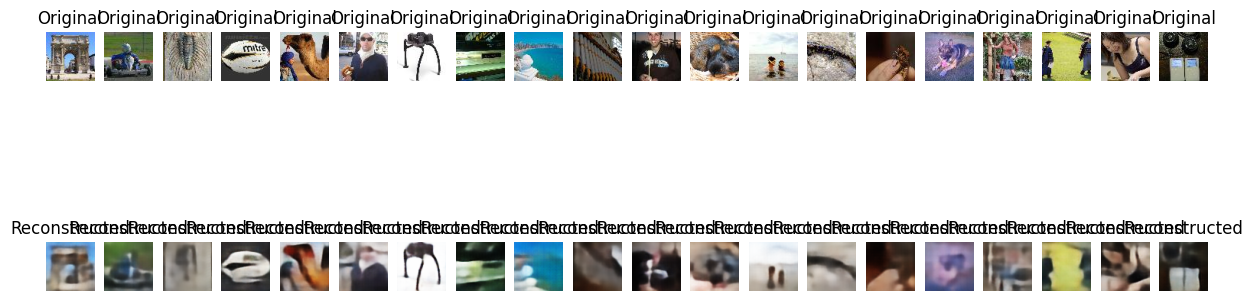

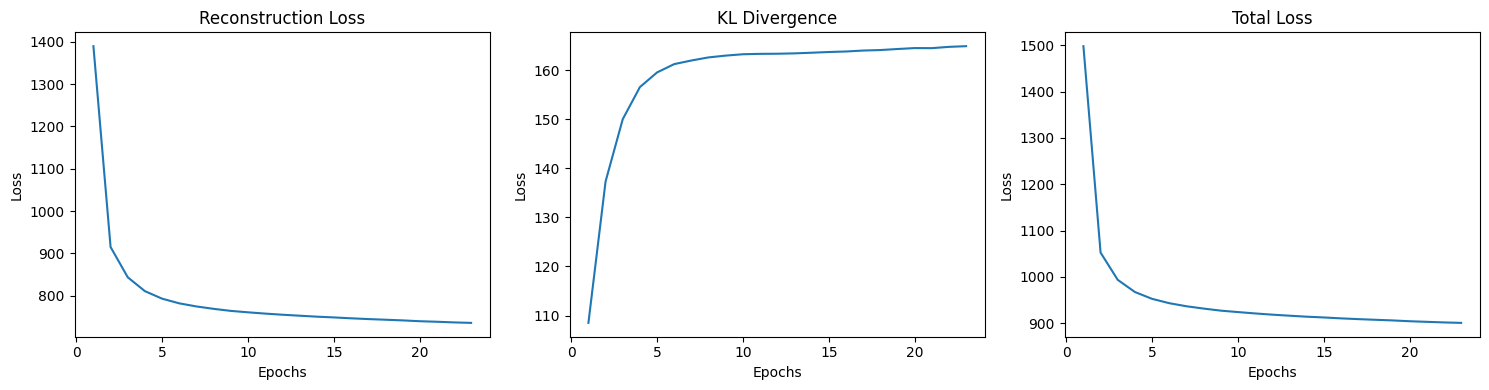

In [ ]:
# Visualization of reconstructions
def visualize_reconstructions(model, dataloader, num_images=20):
    model.eval()
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            recon_x, _, _ = model(x)
            x = x.cpu()
            recon_x = recon_x.cpu()

            plt.figure(figsize=(15, 5))
            for i in range(num_images):
                # Original image
                plt.subplot(2, num_images, i + 1)
                plt.imshow(x[i].permute(1, 2, 0).cpu().numpy()*0.5+0.5)
                plt.axis('off')
                plt.title("Original")

                # Reconstructed image
                plt.subplot(2, num_images, i + 1 + num_images)
                plt.imshow(recon_x[i].permute(1, 2, 0).cpu().numpy()*0.5+0.5)
                plt.axis('off')
                plt.title("Reconstructed")

            plt.show()
            break
#TRAIN THE VAE MODEL WTH 128 LATENT_DIM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
TRAIN_PATH =  './tiny_imagenet200/tiny-imagenet-200/train'
vae = VAE_4_LAYERS(latent_dim).to(device)
dataloader = prepare_data()
history= train_vae_4_layers(vae, dataloader, device)
torch.save(vae.state_dict(), "vae_model.pkl")
visualize_reconstructions(vae, dataloader)


def plot_training_metrics(training_history):
    epochs = range(1, len(training_history["total_loss"]) + 1)

    plt.figure(figsize=(15, 4))
    plt.subplot(131)
    plt.plot(epochs, training_history["reconstruction_loss"])
    plt.title("Reconstruction Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(132)
    plt.plot(epochs, training_history["kl_divergence"])
    plt.title("KL Divergence")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(133)
    plt.plot(epochs, training_history["total_loss"])
    plt.title("Total Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.tight_layout()
    plt.show()



plot_training_metrics(history)

Epoch [1/23], Total Loss: 1543.1700, Reconstruction Loss: 1475.5950, KL Divergence: 67.5750
Epoch [2/23], Total Loss: 1245.3281, Reconstruction Loss: 1171.4426, KL Divergence: 73.8855
Epoch [3/23], Total Loss: 1219.4559, Reconstruction Loss: 1145.7170, KL Divergence: 73.7389
Epoch [4/23], Total Loss: 1208.7842, Reconstruction Loss: 1135.2652, KL Divergence: 73.5190
Epoch [5/23], Total Loss: 1200.7734, Reconstruction Loss: 1127.3977, KL Divergence: 73.3757
Epoch [6/23], Total Loss: 1194.7342, Reconstruction Loss: 1121.4569, KL Divergence: 73.2774
Epoch [7/23], Total Loss: 1189.7974, Reconstruction Loss: 1116.5583, KL Divergence: 73.2391
Epoch [8/23], Total Loss: 1184.8401, Reconstruction Loss: 1111.5943, KL Divergence: 73.2457
Epoch [9/23], Total Loss: 1180.6497, Reconstruction Loss: 1107.4054, KL Divergence: 73.2443
Epoch [10/23], Total Loss: 1176.9081, Reconstruction Loss: 1103.6480, KL Divergence: 73.2601
Epoch [11/23], Total Loss: 1173.6868, Reconstruction Loss: 1100.3736, KL Diverg

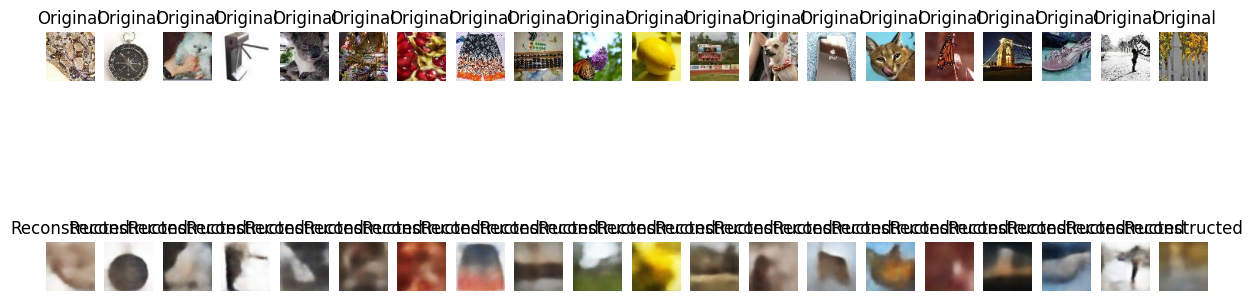

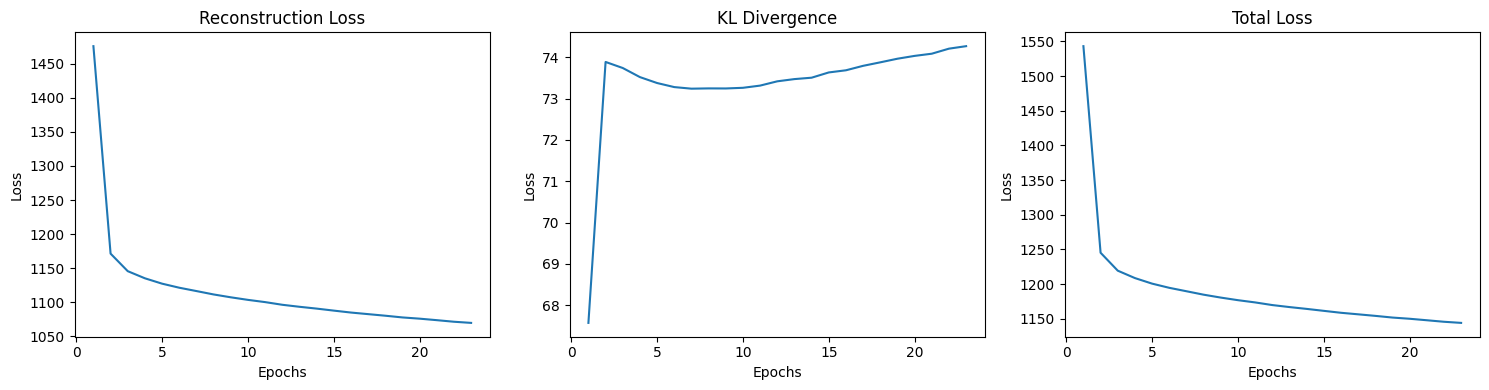

In [ ]:
#TRAIN THE VAE MODEL WTH 32 LATENT_DIM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 32
TRAIN_PATH =  './tiny_imagenet200/tiny-imagenet-200/train'
vae = VAE_4_LAYERS(latent_dim).to(device)
dataloader = prepare_data()
history= train_vae_4_layers(vae, dataloader, device)
#visualize_latent_space(vae, dataloader)

torch.save(vae.state_dict(), "vae_model_32.pkl")
visualize_reconstructions(vae, dataloader)
plot_training_metrics(history)


<ipython-input-126-3c1992de068f>:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("hsv", num_classes)


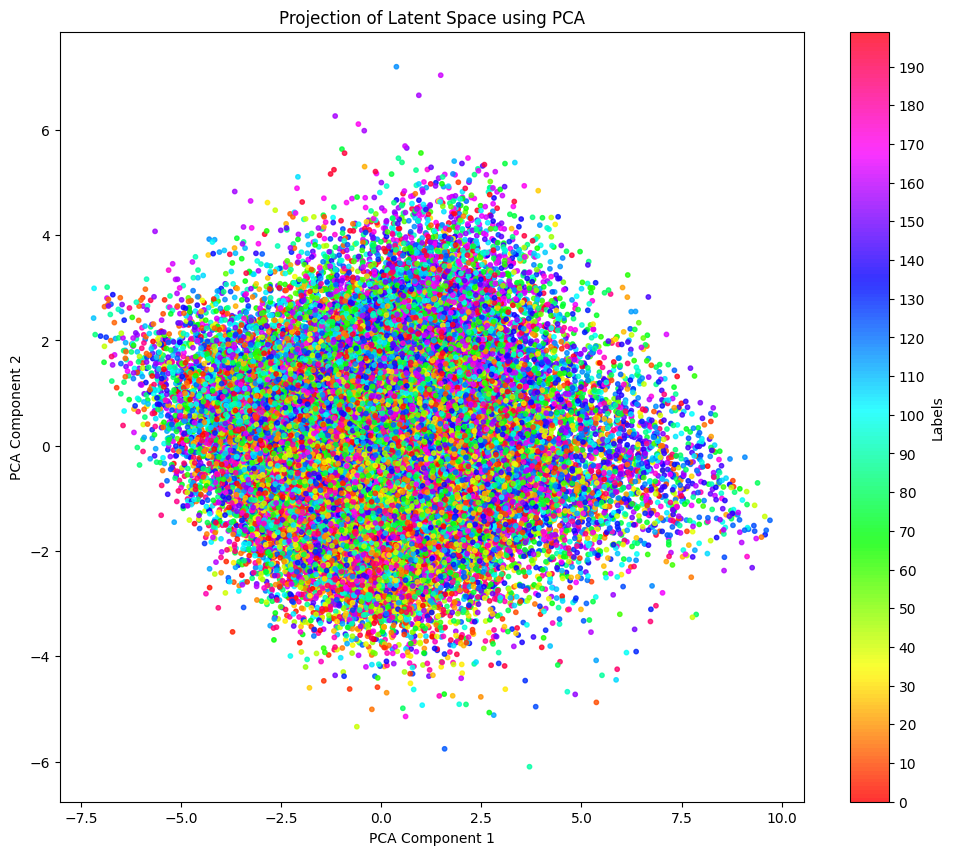

In [ ]:
#PLOT VAE MODEL WITH LATENT DIM=32
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_latent(autoencoder, data, num_batches=500):
    all_z = []
    all_y = []

    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.view(z.shape[0], -1)
        z = z.to('cpu').detach().numpy()

        all_z.append(z)
        all_y.append(y.numpy())

        if i > num_batches:
            break


    all_z = np.vstack(all_z)
    all_y = np.concatenate(all_y)
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(all_z)

    num_classes = len(set(all_y))
    cmap = plt.cm.get_cmap("hsv", num_classes)

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=all_y[:len(z_pca)], cmap=cmap,s=10, alpha=0.8,)
    cbar = plt.colorbar(scatter, label="Labels", ticks=range(0, num_classes, 10))
    cbar.set_ticks(range(0, num_classes, 10))
    cbar.set_ticklabels([f"{i}" for i in range(0, num_classes, 10)])
    plt.title("Projection of Latent Space using PCA")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()



plot_latent(vae, dataloader)

<ipython-input-84-a9888f20ce26>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("hsv", num_classes)


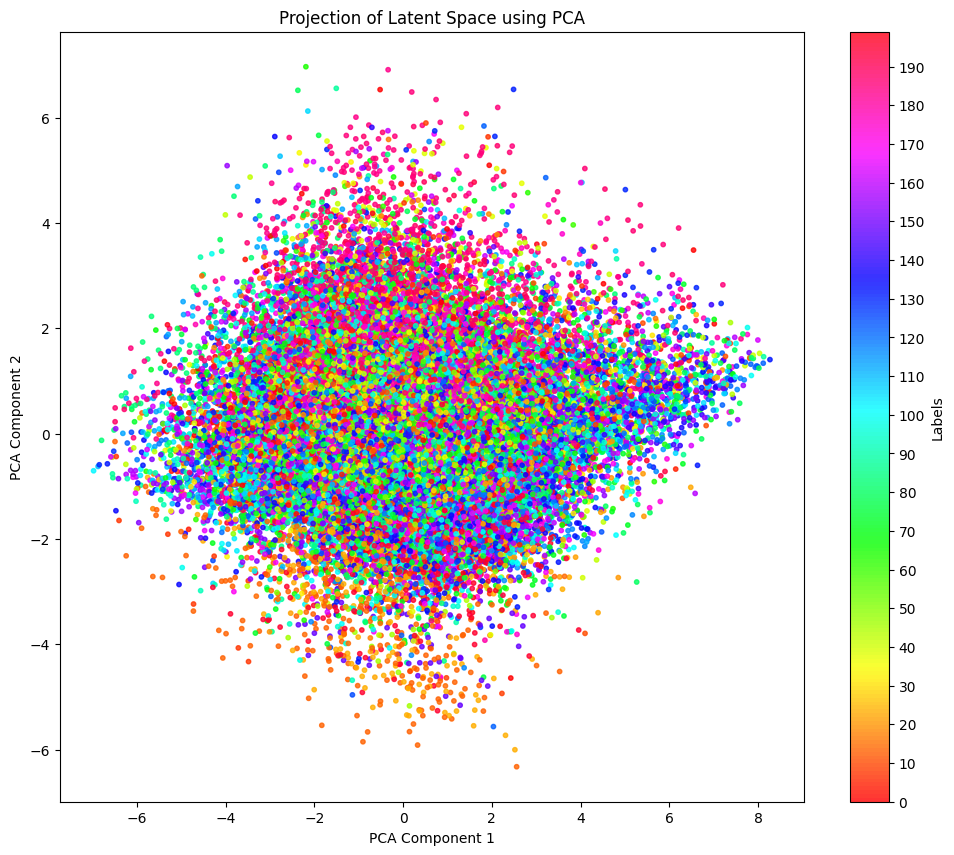

In [ ]:
#PLOT VAE MODEL WITH LATENT DIM=128
plot_latent(vae, dataloader)

In [ ]:
import torch
import numpy as np
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_latent(autoencoder, data, num_batches=500):
    all_z = []
    all_y = []

    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.view(z.shape[0], -1)
        z = z.to('cpu').detach().numpy()

        all_z.append(z)
        all_y.append(y.numpy())

        if i > num_batches:
            break


    all_z = np.vstack(all_z)
    all_y = np.concatenate(all_y)
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(all_z)

    num_classes = len(set(all_y))
    cmap = plt.cm.get_cmap("hsv", num_classes)

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=all_y[:len(z_pca)], cmap=cmap,s=10, alpha=0.8,)
    cbar = plt.colorbar(scatter, label="Labels", ticks=range(0, num_classes, 10))
    cbar.set_ticks(range(0, num_classes, 10))
    cbar.set_ticklabels([f"{i}" for i in range(0, num_classes, 10)])
    plt.title("Projection of Latent Space using PCA")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

def visualize_reconstructions(model, dataloader, num_images=20):
    model.eval()
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            recon_x, _, _ = model(x)
            x = x.cpu()
            recon_x = recon_x.cpu()

            plt.figure(figsize=(15, 5))
            for i in range(num_images):
                # Original image
                plt.subplot(2, num_images, i + 1)
                plt.imshow(x[i].permute(1, 2, 0).cpu().numpy()*0.5+0.5)
                plt.axis('off')
                plt.title("Original")

                # Reconstructed image
                plt.subplot(2, num_images, i + 1 + num_images)
                plt.imshow(recon_x[i].permute(1, 2, 0).cpu().numpy()*0.5+0.5)
                plt.axis('off')
                plt.title("Reconstructed")

            plt.show()
            break
#TRAIN THE VAE MODEL WTH 128 LATENT_DIM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
TRAIN_PATH =  './tiny_imagenet200/tiny-imagenet-200/train'

In [ ]:
def reproduce_hw4(weights_path, data_path, device, num_steps):
    set_seed(20)
    vae = VAE_4_LAYERS(latent_dim).to(device)
    dataloader = prepare_data()

    # Add weights_only=True for security
    vae.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
    vae.eval()

    with torch.no_grad():
        images, _ = next(iter(dataloader))
        image1, image2 = images[0].to(device), images[1].to(device)
        mu1, logvar1 = vae.encode(image1.unsqueeze(0))
        mu2, logvar2 = vae.encode(image2.unsqueeze(0))

        z1 = vae.reparameterize(mu1, logvar1)
        z2 = vae.reparameterize(mu2, logvar2)

        interpolation = torch.linspace(0, 1, num_steps).to(device)
        z_interpolated = torch.stack([z1 * (1 - alpha) + z2 * alpha for alpha in interpolation])

        reconstructed_images = vae.decode(z_interpolated).cpu()

        fig, axes = plt.subplots(2, num_steps, figsize=(15, 5))

        # Normalize images from [-1,1] to [0,1] for visualization
        def normalize_for_display(img):
            return (img.clamp(-1, 1) + 1) / 2

        # Display original images
        axes[0, 0].imshow(normalize_for_display(image1.cpu()).permute(1, 2, 0).numpy())
        axes[0, 0].axis('off')
        axes[0, 0].set_title("Image 1")

        for i in range(1, num_steps - 1):
            axes[0, i].axis('off')

        axes[0, -1].imshow(normalize_for_display(image2.cpu()).permute(1, 2, 0).numpy())
        axes[0, -1].axis('off')
        axes[0, -1].set_title("Image 2")

        # Display interpolated images
        for i, img in enumerate(reconstructed_images):
            normalized_img = normalize_for_display(img)
            axes[1, i].imshow(normalized_img.permute(1, 2, 0).numpy())
            axes[1, i].axis('off')
            axes[1, i].set_title(f"Step {i+1}")

        plt.tight_layout()
        plt.show()
        plot_latent(vae, dataloader)
        visualize_reconstructions(vae, dataloader)


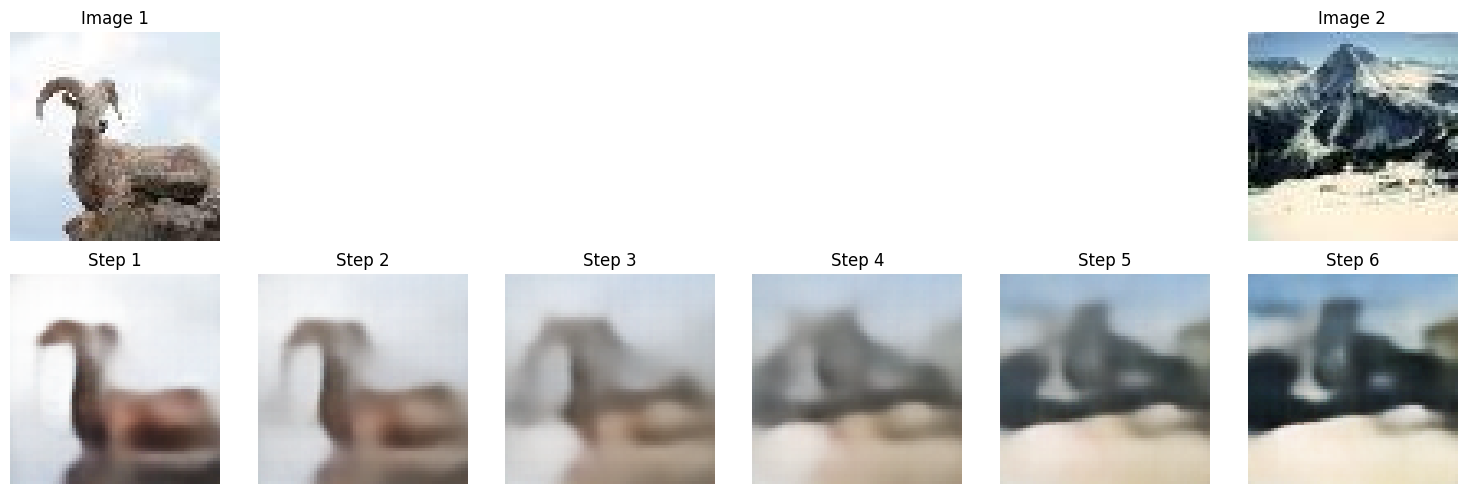

<ipython-input-11-fe396a6df3ad>:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("hsv", num_classes)


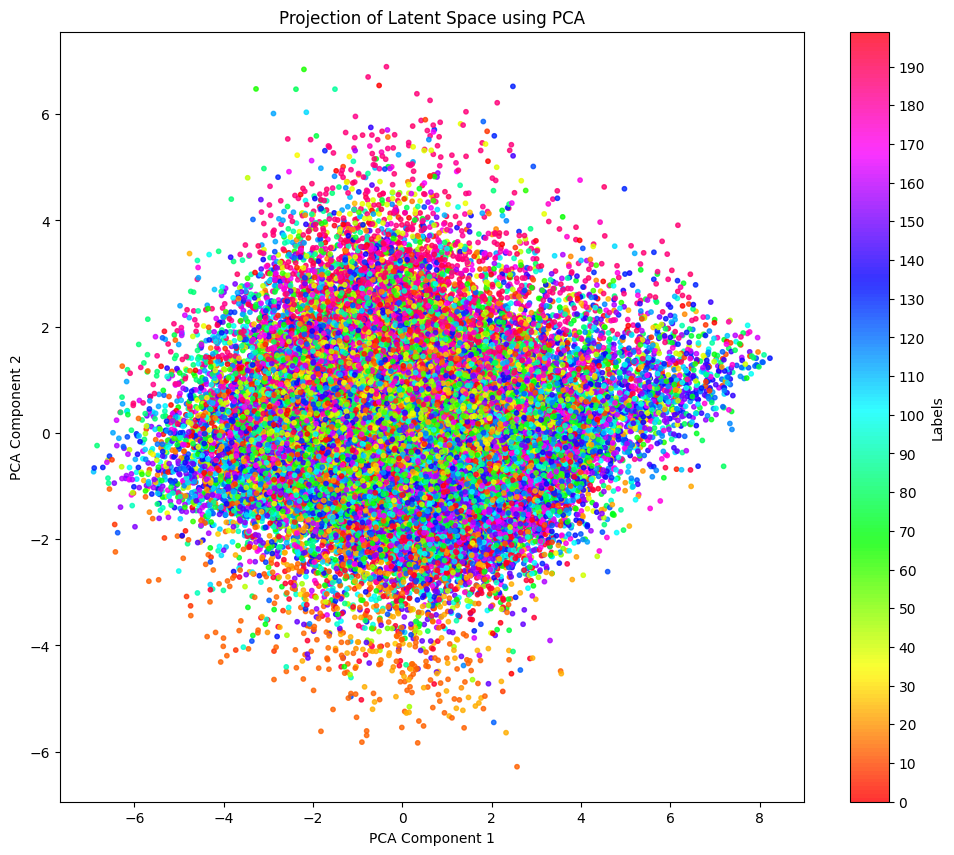

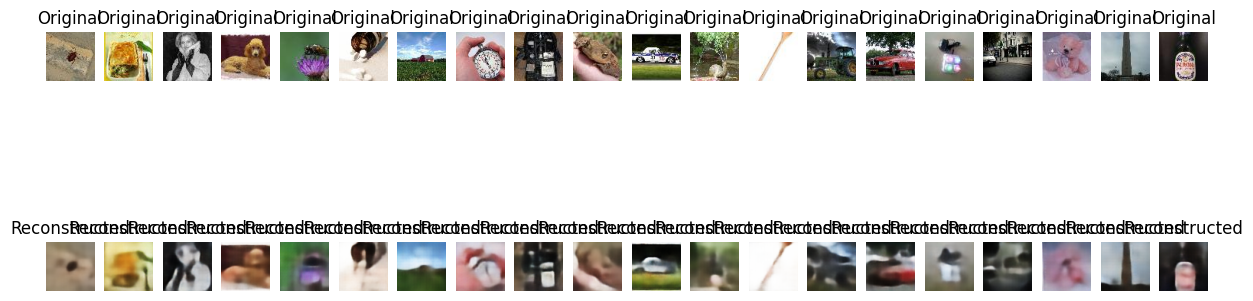

In [ ]:
computation_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reproduce_hw4("/content/vae_model_4_layers_final_version.pkl", TRAIN_PATH, computation_device, 6)

In [ ]:
pip freeze > requirements.txt